In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

def rcsetup():
    plt.rc("figure", dpi=150, facecolor=(1, 1, 1))
    plt.rc("font", family='palatino linotype', size=14)
    plt.rc("axes", facecolor=(1, .99, .95), titlesize=18)
    plt.rc("mathtext", fontset='cm')
rcsetup()

import sys
sys.path.insert(0, '../../more-is-better')
from exptdetails import ExptDetails
from ExperimentResults import ExperimentResults


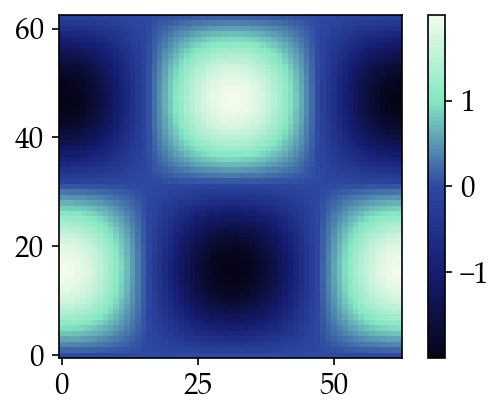

In [5]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap


import matplotlib.cm as cm
from matplotlib.colors import LogNorm

# https://colordesigner.io/gradient-generator

def get_color(i, palnum=3):
    colors = {
        0: [
            "xkcd:pastel pink",
            "xkcd:bubblegum pink",
            "xkcd:purplish pink",
            "xkcd:bluish purple",
            "xkcd:ultramarine",],
        1: [
            "#86d4f8",
            "#478fe8",
            "#2544bb",
            "#222071",
            "#1a1230",],
        2: [
            "#f8c3e7",
            "#e578d5",
            "#c439c7",
            "#672d74",
            "#25172d",],
        3: [
            "#f1c361",
            "#e59231",
            "#bd5e1f",
            "#85361b",
            "#511b14",
        ],
        3: [
            "#f8aee0",
            "#e383f2",
            "#9559e9",
            "#474dc8",
            "#0641b7",
        ],
        4: "#2b2f57 #5c3490 #c73acd #e763a8 #f79595".split(' '),
        5: "#050417 #151d71 #2d48a1 #85e7c3 #f3fbeb".split(' ')
    }
    return colors[palnum][i%5]

# x = np.linspace(0, 1)
# for i in range(5):
#     plt.plot(x, (1+i)/5 * x, color=get_color(i, 2))
# plt.show()

x = np.arange(0, 2 * np.pi, 0.1)
y = np.arange(0, 2 * np.pi, 0.1)
X, Y = np.meshgrid(x, y)
Z = np.cos(X) * np.sin(Y) * 2

colors = [get_color(i, 5) for i in range(5)]
cmap = LinearSegmentedColormap.from_list('my_list', colors, N=256)
fig = plt.figure(figsize=(4, 3))
# Create the colormap
# Fewer bins will result in "coarser" colomap interpolation
im = plt.imshow(Z, origin='lower', cmap=cmap)
fig.colorbar(im, ax=plt.gca())
plt.tight_layout()
plt.show()

## RF

In [137]:
DATASET_NAME = 'cifar10'
expt_info = ExptDetails(1, 1, DATASET_NAME)
work_dir = f"../results/{DATASET_NAME}/{expt_info.expt_name}"

def do_nplot(ax, sm, expt, theory, M):
    ridges = expt.get_axis("ridge")
    
    for ridge in ridges[[4, 8, 12, 20, 26]]:
        color = sm.to_rgba(ridge)
        
        n = expt.get_axis("n")
        expt_train_mse, err = expt.get(stats_axis='trial', k=256, ridge=ridge, result="train_mse")
        ax.errorbar(n, expt_train_mse, yerr=err, ls='none', marker='.', markersize=6,
                    markeredgewidth=0, color=color, alpha=0.3, zorder=0)

        expt_test_mse, err = expt.get(stats_axis='trial', k=256, ridge=ridge, result="test_mse")
        ax.errorbar(n, expt_test_mse, yerr=err, ls='none', color=color, marker='.', markersize=6)

        n = theory.get_axis("n")
        kappa = theory.get(k=256, ridge=ridge, result="kappa")
        theory_test_mse = theory.get(k=256, ridge=ridge, result="test_mse")
        theory_train_mse = theory_test_mse * (ridge / (n * kappa))**2
        theory_test_mse = (M * theory_test_mse - n * theory_train_mse) / (M-n)
        theory_train_mse = theory_test_mse * (ridge / (n * kappa))**2
        ax.plot(n, theory_train_mse, ls=":", color=color, alpha=0.3)    
        ax.plot(n, theory_test_mse, color=color)
        
    optridge = expt.get(stats_axis='trial', k=256, result="test_mse")[0].min(axis=1)
    n = expt.get_axis("n")
    ax.plot(n, optridge, color="xkcd:deep sky blue", lw=2, ls='--', zorder=5)
    

def do_kplot(ax, sm, expt, theory, n, M):
    ridges = expt.get_axis("ridge")
    
    for ridge in ridges[[4, 8, 12, 20, 26]]:
        color = sm.to_rgba(ridge)
        
        kk = expt.get_axis("k")
        expt_train_mse, err = expt.get(stats_axis='trial', n=256, ridge=ridge, result="train_mse")
        ax.errorbar(kk, expt_train_mse, yerr=err, ls='none', marker='.', markersize=6,
                    markeredgewidth=0, color=color, alpha=0.3, zorder=0)

        expt_test_mse, err = expt.get(stats_axis='trial', n=256, ridge=ridge, result="test_mse")
        ax.errorbar(kk, expt_test_mse, yerr=err, ls='none', color=color, marker='.', markersize=6)

        kk = theory.get_axis("k")
        kappa = theory.get(n=256, ridge=ridge, result="kappa")
        theory_test_mse = theory.get(n=256, ridge=ridge, result="test_mse")
        theory_train_mse = theory_test_mse * (ridge / (n * kappa))**2
        theory_test_mse = (M * theory_test_mse - n * theory_train_mse) / (M-n)
        theory_train_mse = theory_test_mse * (ridge / (n * kappa))**2
        ax.plot(kk, theory_train_mse, ls=":", color=color, alpha=0.3)    
        ax.plot(kk, theory_test_mse, color=color)
    
    optridge = expt.get(stats_axis='trial', n=256, result="test_mse")[0].min(axis=1)
    k = expt.get_axis("k")
    ax.plot(k, optridge, color="xkcd:deep sky blue", lw=2, ls='--', zorder=5)

In [189]:
expt = ExperimentResults.load(f"{work_dir}/expt-gaussian-n256.expt")
ridges = expt.get_axis("ridge")
print(ridges[[4, 8, 12, 20, 26]])

[4.64158883e-03 2.15443469e-02 1.00000000e-01 2.15443469e+00
 2.15443469e+01]


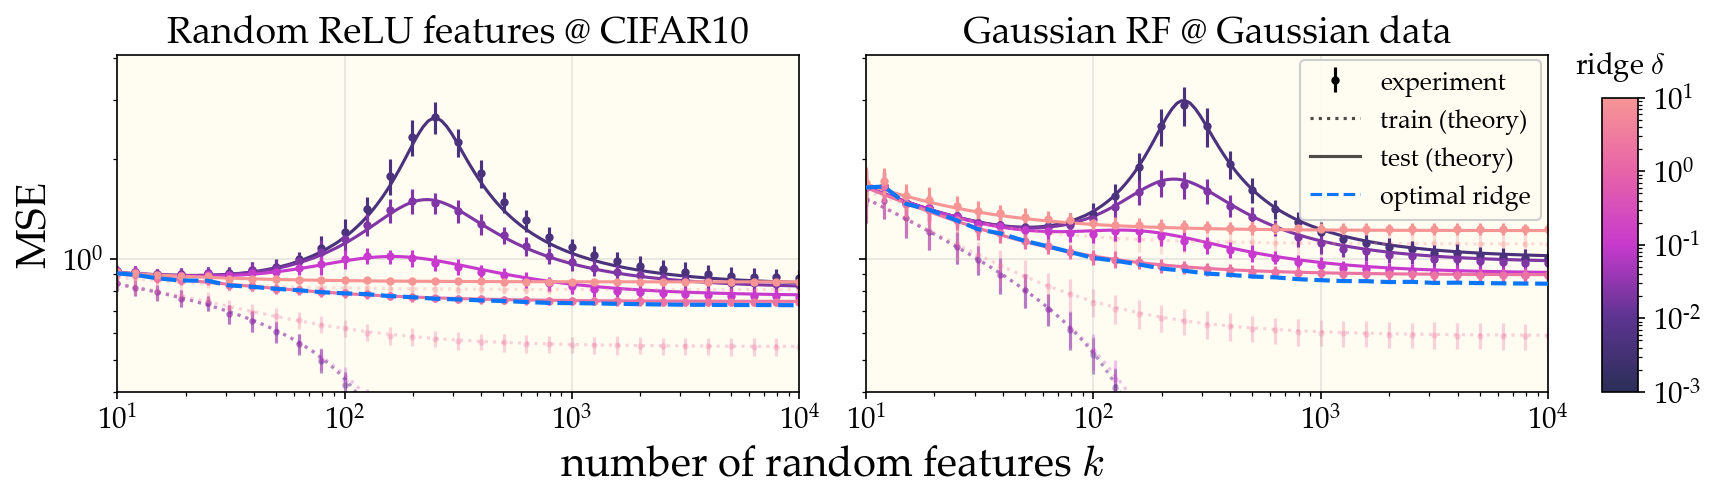

In [188]:
colors = [get_color(i, 4) for i in range(5)]
cmap = LinearSegmentedColormap.from_list('my_list', colors, N=256)

# Fixed n=256
M = 10000
n = 256

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(12,2.8))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=10**-3, vmax=10**1))

plot_params = {
    "ids": ["", "gaussian-"],
    "titles": ["Random ReLU features @ CIFAR10", "Gaussian RF @ Gaussian data"],
}

for i, ax in enumerate(axes):
    id = plot_params["ids"][i]
    expt = ExperimentResults.load(f"{work_dir}/expt-{id}n256.expt")
    theory = ExperimentResults.load(f"{work_dir}/theory-{id}n256.expt")
    
    do_kplot(ax, sm, expt, theory, n, M)

    ax.set_title(plot_params["titles"][i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim(1e1, 1e4)
    ax.set_ylim(4e-1, 4.1e0)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('number of random features $k$', size="x-large")
plt.ylabel('MSE', size="x-large")
plt.tight_layout()
fig.subplots_adjust(bottom=0, right=0.9)
cbar_ax = fig.add_axes([0.93, 0.0, 0.02, 0.7])
fig.colorbar(sm, cax=cbar_ax) # label the colorbar?
cbar_ax.set_title("ridge $\delta$", pad=12, fontsize=14)

line = Line2D([],[], ls='none', marker='.', markersize=6, color='k')
barline = LineCollection(np.empty((2,2,2)), color='k')
plt.figlegend(
    (
        ErrorbarContainer((line, [], [barline]), has_xerr=False, has_yerr=True),
        Line2D([0], [0], color='k', alpha=0.7, ls=':'),
        Line2D([0], [0], color='k', alpha=0.7, ls='-'),
        Line2D([0], [0], color='xkcd:deep sky blue', alpha=1, ls='--'),),
    (
        "experiment",
        "train (theory)",
        "test (theory)",
        "optimal ridge",),
    fontsize=12,
    bbox_to_anchor=(.903, .82),
    loc="upper right",
    framealpha=0.95,
)
plt.savefig("rf-n256.pdf", bbox_inches="tight")

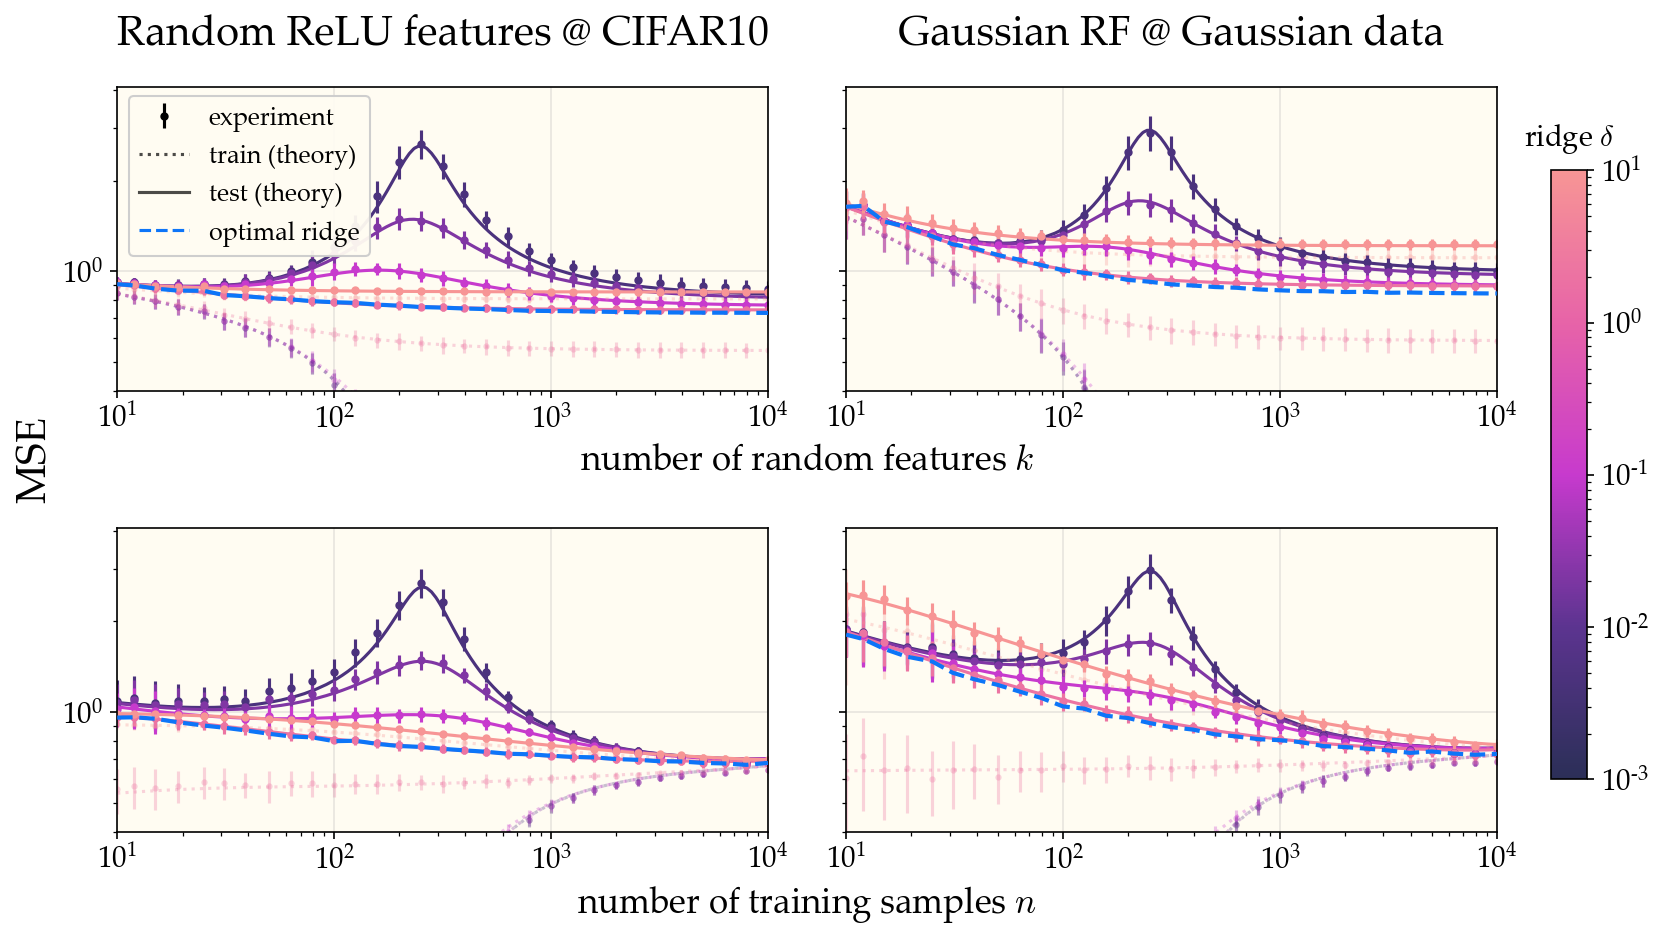

In [187]:
colors = [get_color(i, 4) for i in range(5)]
cmap = LinearSegmentedColormap.from_list('my_list', colors, N=256)

# Fixed k=256
M = 20001
k = 256

fig, axes = plt.subplots(ncols=2, nrows=2, sharey=True, figsize=(12,5.8))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=LogNorm(vmin=10**-3, vmax=10**1))

col_params = {
    "ids": ["", "gaussian-"],
    "titles": ["Random ReLU features @ CIFAR10", "Gaussian RF @ Gaussian data"],
}
row_params = {
    "plottype": ["n", "k"]
}

for j, ax in enumerate(axes[0]):
    title = col_params["titles"][j]
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

# Create additional axes for x-labels
toprow = fig.add_subplot(211, frameon=False)
toprow.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
toprow.set_xlabel('number of random features $k$', size="large")
bottomrow = fig.add_subplot(212, frameon=False)
bottomrow.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
bottomrow.set_xlabel('number of training samples $n$', size="large")

for (i, j), ax in np.ndenumerate(axes):
    plottype = row_params["plottype"][i]
    id = col_params["ids"][j]
    expt = ExperimentResults.load(f"{work_dir}/expt-{id}{plottype}256.expt")
    theory = ExperimentResults.load(f"{work_dir}/theory-{id}{plottype}256.expt")
    
    if i == 0:
        do_kplot(ax, sm, expt, theory, 256, M)
    else:
        do_nplot(ax, sm, expt, theory, M)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim(1e1, 1e4)
    ax.set_ylim(4e-1, 4.1e0)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel('MSE', size="x-large")
plt.tight_layout()
fig.subplots_adjust(bottom=0, right=0.9)
fig.subplots_adjust(hspace=0.45, wspace=0.12)
cbar_ax = fig.add_axes([0.93, 0.06, 0.02, 0.7])
fig.colorbar(sm, cax=cbar_ax) # label the colorbar?
cbar_ax.set_title("ridge $\delta$", pad=12, fontsize=14)

line = Line2D([],[], ls='none', marker='.', markersize=6, color='k')
barline = LineCollection(np.empty((2,2,2)), color='k')
plt.figlegend(
    (
        ErrorbarContainer((line, [], [barline]), has_xerr=False, has_yerr=True),
        Line2D([0], [0], color='k', alpha=0.7, ls=':'),
        Line2D([0], [0], color='k', alpha=0.7, ls='-'),
        Line2D([0], [0], color='xkcd:deep sky blue', alpha=1, ls='--'),),
    (
        "experiment",
        "train (theory)",
        "test (theory)",
        "optimal ridge",),
    fontsize=12,
    bbox_to_anchor=(.133, .86),
    loc="upper left",
    framealpha=0.95,
)
plt.savefig("rf-nk-traces.pdf", bbox_inches="tight")

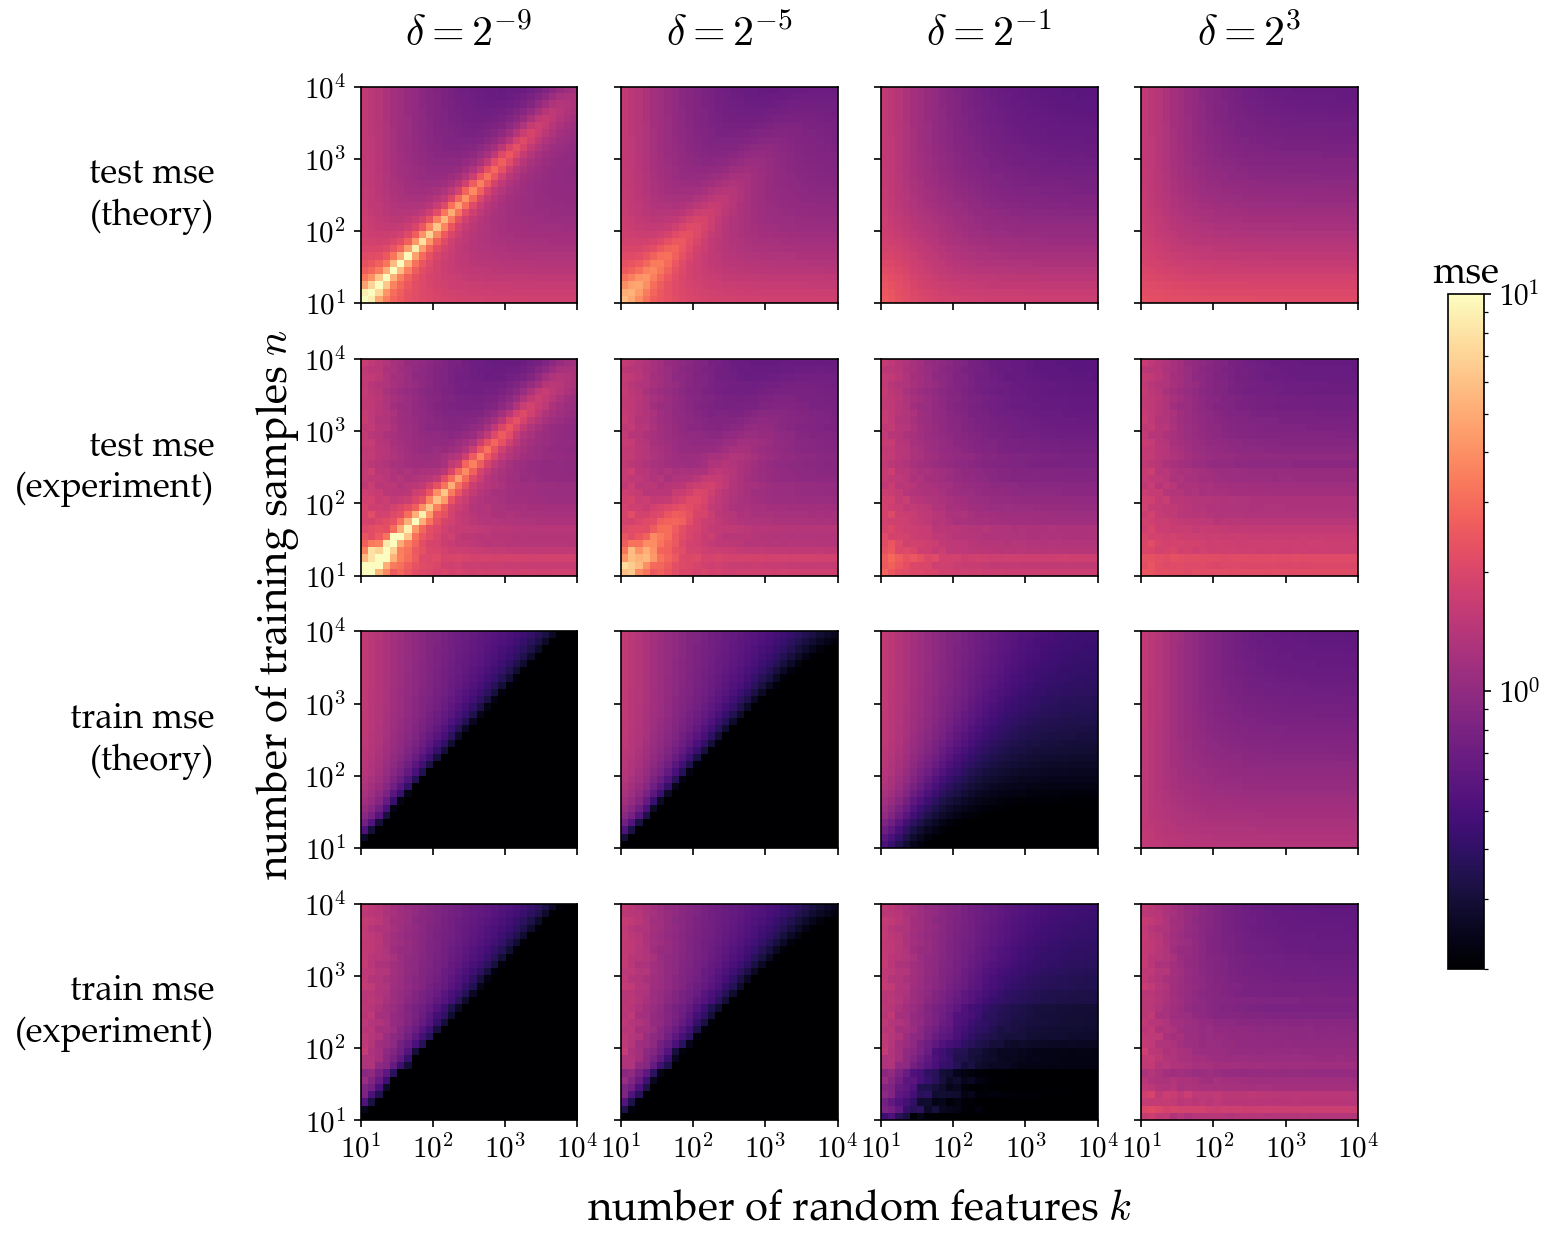

In [185]:
expt = ExperimentResults.load(f"{work_dir}/expt-gaussian-grid.expt")
theory = ExperimentResults.load(f"{work_dir}/theory-gaussian-grid.expt")

ridges = expt.get_axis("ridge")[3::4]
cols = [f'$\\delta=2^{{{int(np.log2(ridge))}}}$' for ridge in ridges]
rows = ["test mse\n(theory)", "test mse\n(experiment)", "train mse\n(theory)", "train mse\n(experiment)"]
nrows = len(rows)
ncols = len(cols)
fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(12,9))

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 35, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

ticks = [1, 2, 3, 4]
ticklabels = [f"$10^{{{i}}}$" for i in ticks]

for i in range(nrows):
    for j in range(ncols):
        ridge = ridges[j]
        if i==0 or i==2:
            test_mse = theory.get(ridge=ridge, result="test_mse")
            kappa = theory.get(ridge=ridge, result="kappa")
            n = theory.get_axis("n")[:, None]
            train_mse = (ridge / (n * kappa))**2 * test_mse
            results = test_mse if i==0 else train_mse
        if i==1:
            results, _ = expt.get(stats_axis="trial", ridge=ridge, result="test_mse")
        if i==3:
            results, _ = expt.get(stats_axis="trial", ridge=ridge, result="train_mse")

        ax = axes[i, j]
        im = ax.imshow(results[:30, :30], cmap='magma', origin='lower', extent=(1, 4, 1, 4),
                       norm=LogNorm(vmin=2e-1, vmax=1e1))
        # ax.hlines(y=np.log10(256), xmin=1, xmax=4, color="xkcd:sky blue", ls="--", alpha=0.7)

        ax.set_xticks(ticks, ticklabels, size="medium")
        ax.set_yticks(ticks, ticklabels, size="medium")
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("number of random features $k$", size="x-large")
plt.ylabel("number of training samples $n$", size="x-large")

fig.tight_layout()

fig.subplots_adjust(right=0.8)
fig.subplots_adjust(hspace=0.1, wspace=0.2)
cbar_ax = fig.add_axes([0.85, 0.25, 0.02, 0.5])
fig.colorbar(im, cax=cbar_ax) # label the colorbar?
cbar_ax.set_title("mse")

plt.savefig("rf-gaussian-grid.pdf", bbox_inches="tight")

## Powerlaw estimation

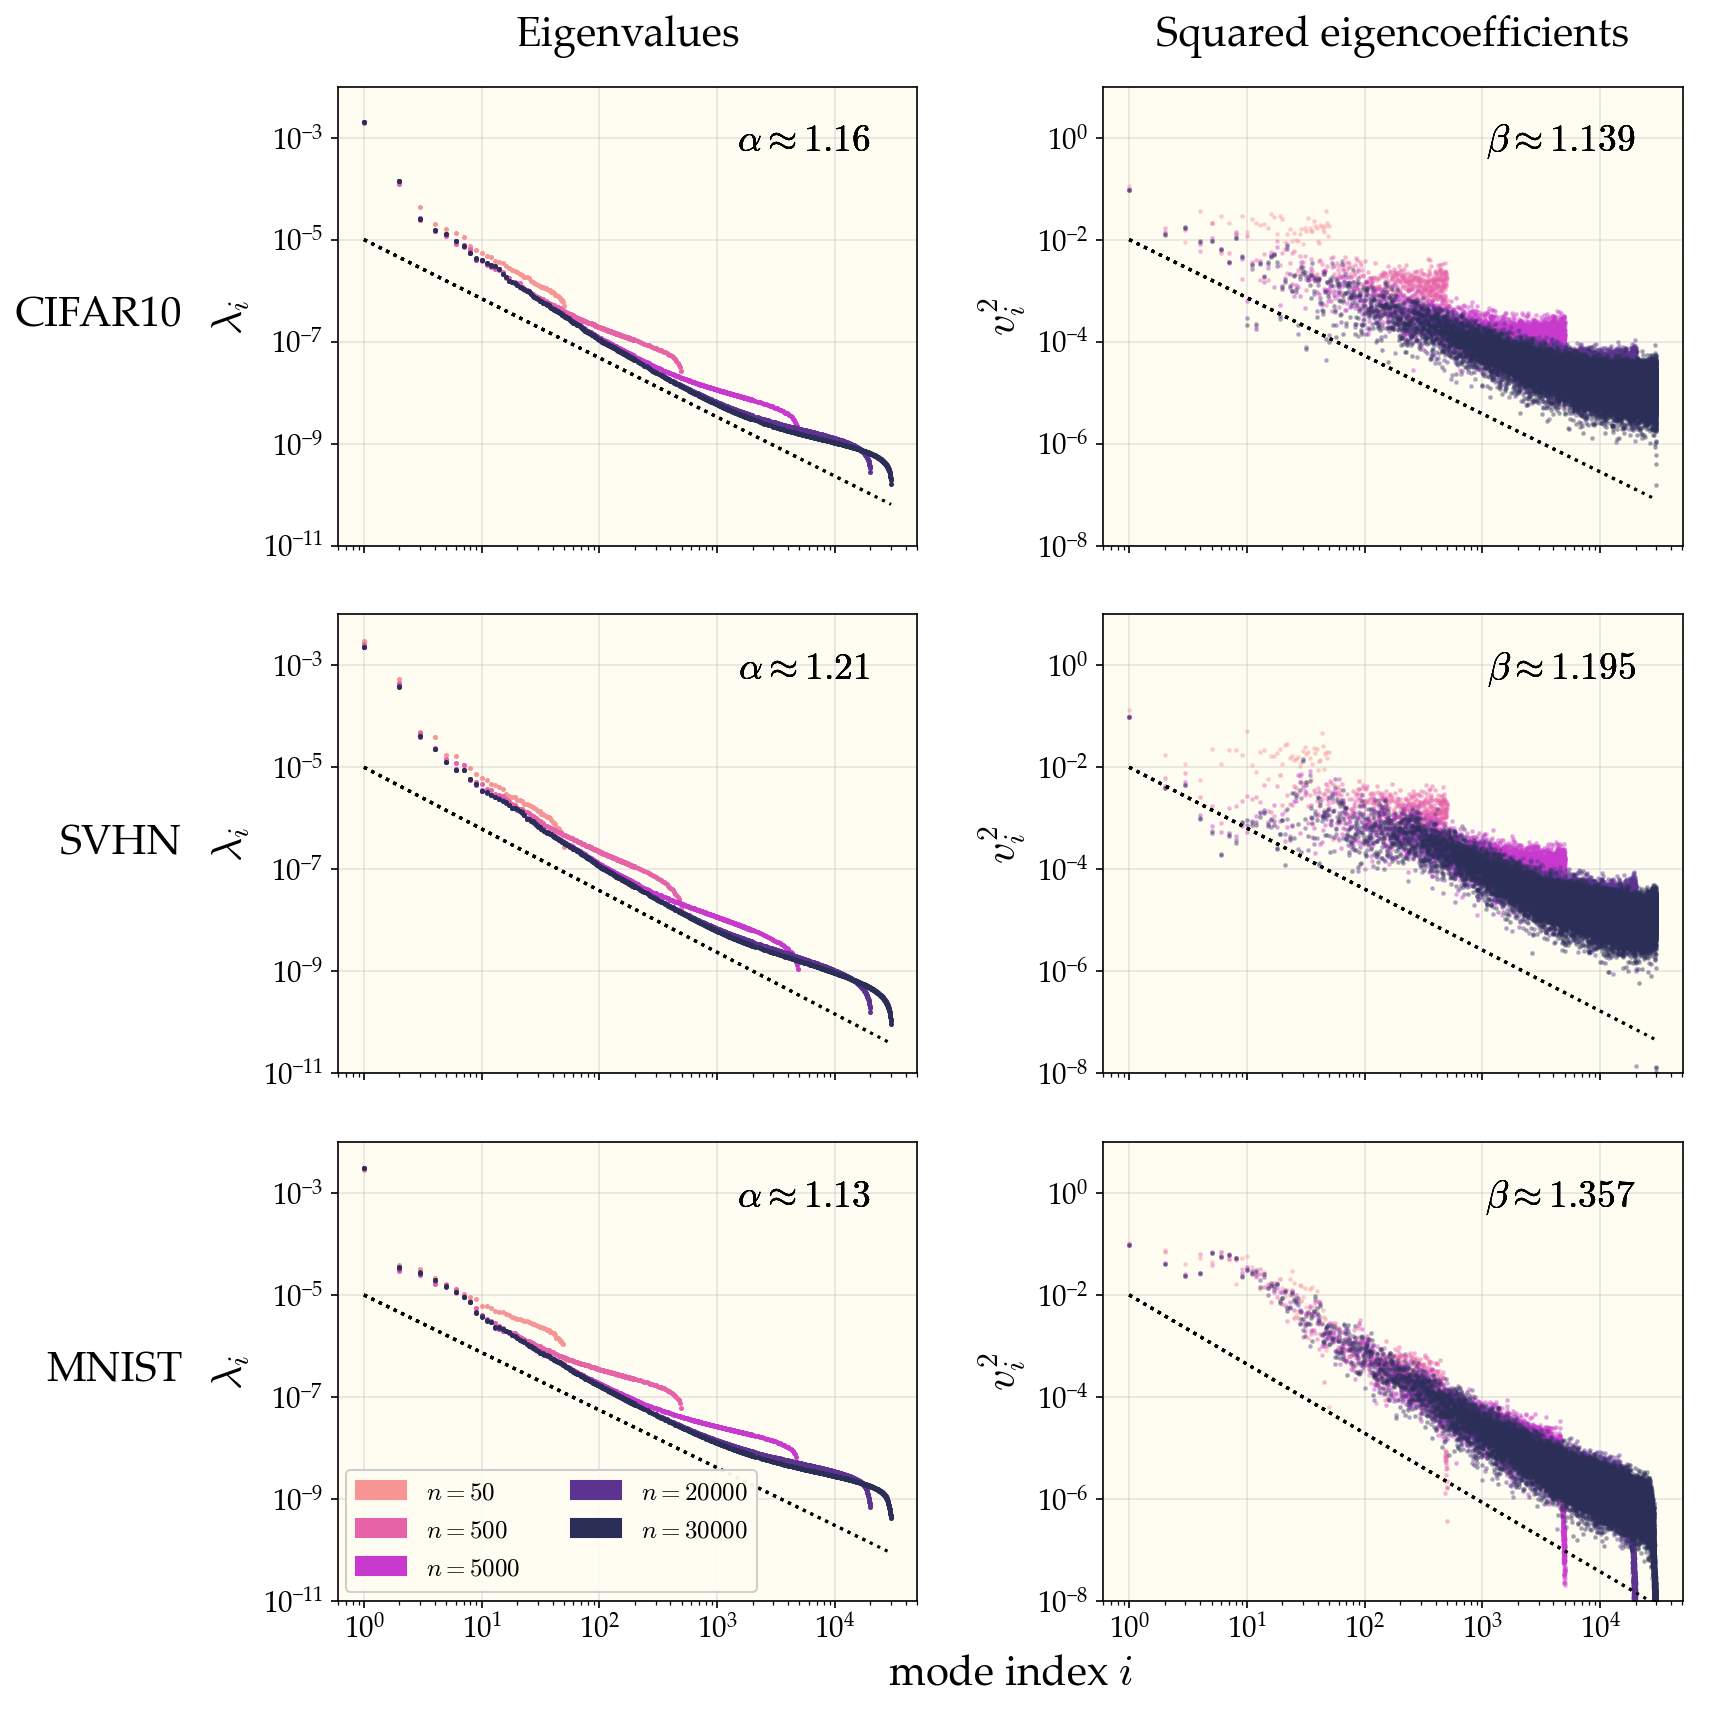

In [75]:
colors = [get_color(i, 4) for i in range(5)]
cmap = 4

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(12,12))

row_params = {
    "dataset": ["cifar10", "svhn", "mnist"],
    "title": ["CIFAR10", "SVHN", "MNIST"],
    "exponents": [(1.16, 1.139), (1.21, 1.195), (1.13, 1.357)]
}
col_params = {
    "title": ["Eigenvalues", "Squared eigencoefficients",],
    "ylim": [(1e-11, 1e-2), (1e-8, 1e1)],
    "ylabel": ["$\\lambda_i$", "$v_i^2$"],
    "plstart": [1e-5, 1e-2]
}

for j, ax in enumerate(axes[0]):
    title = col_params["title"][j]
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

# Create additional axes for x-labels
for i, ax in enumerate(axes[:, 0]):
    title = row_params["title"][i]
    ax.annotate(title, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 10, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')

eig_n = None
for (i, j), ax in np.ndenumerate(axes):
    dataset_name = row_params['dataset'][i]
    expt = ExptDetails(0, 10, dataset_name)
    work_dir = f"../results/{dataset_name}/{expt.expt_name}"
    with open(f"{work_dir}/eigdata.file", 'rb') as handle:
        eigdata = pickle.load(handle)
    with open(f"{work_dir}/eigstats.file", 'rb') as handle:
        eigstats = pickle.load(handle)

    alpha, beta = row_params['exponents'][i]
    eig_n = list(eigdata.keys())
    ymin, ymax = col_params["ylim"][j]
    for k, n in enumerate(eig_n):
        color = get_color(4-k, cmap)
        C = col_params["plstart"][j]
        if j == 0:
            eigvals = eigdata[n]["eigvals"]
            idxs = 1 + np.arange(len(eigvals))
            # plt.plot(idxs, thingy(idxs, 1.3, 0.02))
            # USE INT LOGSPACE
            ax.scatter(idxs[:200], eigvals[:200], s=2, color=color)
            ax.scatter(idxs[200:2000:10], eigvals[200:2000:10], s=2, color=color)
            ax.scatter(idxs[2000::100], eigvals[2000::100], s=2, color=color)
            ax.plot(idxs, C * idxs**-alpha, ls=':', color='k')
            ax.text(2e4, ymax/5, f"$\\alpha\\approx{alpha:.2f}$",
                    fontsize=18, ha='right', va='top')
        else:
            eigcoeffs_full = eigdata[n]["eigcoeffs"]
            eigcoeffs = np.linalg.norm(eigcoeffs_full, axis=-1)**2
            # eigcoeffs = sorted(eigcoeffs, reverse=True)
            idxs = 1 + np.arange(len(eigcoeffs))
            ax.scatter(idxs, eigcoeffs, s=2, alpha=.3, color=color)
            # ax.scatter(idxs, eigcoeffs, s=8, lw=0, alpha=.3, color=color)
            ax.plot(idxs, C * idxs**-beta, ls=':', color='k')
            ax.text(2e4, ymax/5, f"$\\beta\\approx{beta:.3f}$",
                    fontsize=18, ha='right', va='top')

    ax.set_ylabel(col_params["ylabel"][j], size="x-large")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('mode index $i$', size="x-large")
plt.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.32)
plt.figlegend(
    (
        *[Patch(color=get_color(4-i, cmap)) for i in range(5)],),
    (
        *[f"$n={eig_n[i]}$" for i in range(5)],),
    fontsize=12,
    ncol=2,
    bbox_to_anchor=(.223, .093),
    loc="lower left",
    framealpha=0.95,
)
# plt.show()
plt.savefig("eigenspectra.pdf", bbox_inches="tight")

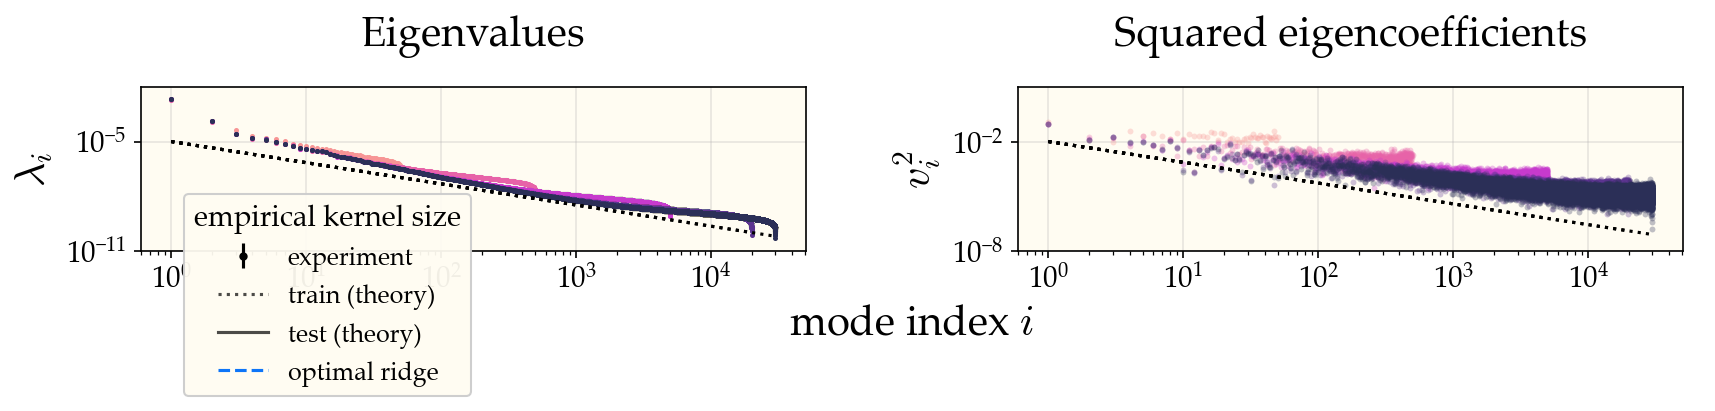

In [45]:
colors = [get_color(i, 4) for i in range(5)]
cmap = 4

fig, axes = plt.subplots(ncols=2, nrows=1, sharex=True, figsize=(12,3))

row_params = {
    "dataset": ["cifar10", "svhn", "mnist"],
    "title": ["CIFAR10", "SVHN", "MNIST"],
    "exponents": [(1.16, 1.139), (1.21, 1.195), (1.13, 1.357)]
}
col_params = {
    "title": ["Eigenvalues", "Squared eigencoefficients",],
    "ylim": [(1e-11, 1e-2), (1e-8, 1e1)],
    "ylabel": ["$\\lambda_i$", "$v_i^2$"],
    "plstart": [1e-5, 1e-2]
}

for j, ax in enumerate(axes[0]):
    title = col_params["title"][j]
    ax.annotate(title, xy=(0.5, 1), xytext=(0, 20),
                xycoords='axes fraction', textcoords='offset points',
                size='x-large', ha='center', va='baseline')

# Create additional axes for x-labels
for i, ax in enumerate(axes[:, 0]):
    title = row_params["title"][i]
    ax.annotate(title, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 10, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='x-large', ha='right', va='center')
    # row = fig.add_subplot(3, 1, i+1, frameon=False)
    # row.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    # row.set_ylabel(title, size="large")

eig_n = None
for (i, j), ax in np.ndenumerate(axes):
    dataset_name = row_params['dataset'][i]
    expt = ExptDetails(0, 10, dataset_name)
    work_dir = f"../results/{dataset_name}/{expt.expt_name}"
    with open(f"{work_dir}/eigdata.file", 'rb') as handle:
        eigdata = pickle.load(handle)
    with open(f"{work_dir}/eigstats.file", 'rb') as handle:
        eigstats = pickle.load(handle)

    alpha, beta = row_params['exponents'][i]
    eig_n = list(eigdata.keys())
    ymin, ymax = col_params["ylim"][j]
    for k, n in enumerate(eig_n):
        color = get_color(4-k, cmap)
        C = col_params["plstart"][j]
        if j == 0:
            eigvals = eigdata[n]["eigvals"]
            idxs = 1 + np.arange(len(eigvals))
            # plt.plot(idxs, thingy(idxs, 1.3, 0.02))
            ax.scatter(idxs, eigvals, s=2, color=color)
            ax.plot(idxs, C * idxs**-alpha, ls=':', color='k')
            ax.text(2e4, ymax/5, f"$\\alpha\\approx{alpha:.2f}$",
                    fontsize=18, ha='right', va='top')
        else:
            eigcoeffs_full = eigdata[n]["eigcoeffs"]
            eigcoeffs = np.linalg.norm(eigcoeffs_full, axis=-1)**2
            # eigcoeffs = sorted(eigcoeffs, reverse=True)
            idxs = 1 + np.arange(len(eigcoeffs))
            ax.scatter(idxs, eigcoeffs, s=8, lw=0, alpha=.3, color=color)
            ax.plot(idxs, C * idxs**-beta, ls=':', color='k')
            ax.text(2e4, ymax/5, f"$\\beta\\approx{beta:.3f}$",
                    fontsize=18, ha='right', va='top')

    ax.set_ylabel(col_params["ylabel"][j], size="x-large")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(ymin, ymax)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('mode index $i$', size="x-large")
plt.tight_layout()
fig.subplots_adjust(hspace=0.15, wspace=0.32)
plt.figlegend(
    (
        *[Patch(color=get_color(4-i, cmap)) for i in range(5)],),
    (
        *[f"$n={eig_n[i]}$" for i in range(5)],),
    fontsize=12,
    ncol=2,
    bbox_to_anchor=(.223, .093),
    loc="lower left",
    framealpha=0.95,
)
plt.savefig("eigenspectra.pdf", bbox_inches="tight")

0.3520421936098166
1.4743137
7.749544532114747e-08


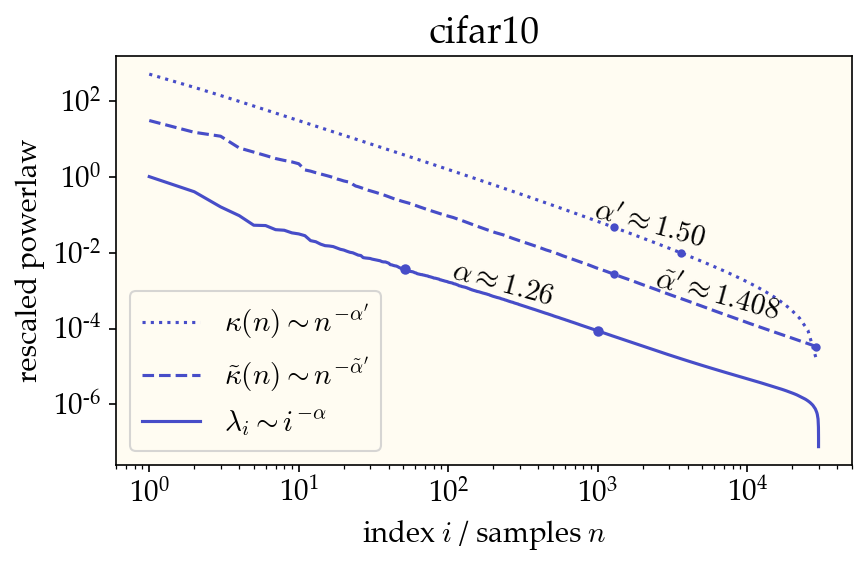

In [260]:

DATASET_NAME = 'cifar10'
EXPT_NUM = 1
DEPTH = 1

expt = ExptDetails(EXPT_NUM, DEPTH, DATASET_NAME)
work_dir = f"results/{DATASET_NAME}/{expt.expt_name}"
with open(f"{work_dir}/eigdata.file", 'rb') as handle:
    eigdata = pickle.load(handle)
with open(f"{work_dir}/eigstats.file", 'rb') as handle:
    eigstats = pickle.load(handle)
    
ax = plt.gca()

eigvals = eigstats["eigvals"]
print(eigvals.max())
n = len(eigvals)
idxs = 1 + np.arange(n)

sizes = eigstats["sizes"]
f1, f2 = 500, 30
all_endpts = [[50, 1000], [30, 1000], [80, 6000], [20, 300]]
rot = -15
lift = 1.6

kappas = eigstats["true_kappas"]
kappas /= kappas.max()
kappa_estims = eigstats["kappa_estimates"]
kappa_estims /= kappa_estims.max()
eigvals = eigvals / eigvals[0]
color = get_color(3)
ax.plot(sizes, f1*kappas, color=color, ls=":", label="$\\kappa(n)\\sim n^{-\\alpha'}$")
ax.plot(sizes, f2*kappa_estims, color=color, ls="--", label="$\\tilde{\\kappa}(n)\\sim n^{-\\tilde{\\alpha}'}$")
ax.plot(idxs, eigvals, color=color, label="$\\lambda_i\\sim i^{-\\alpha}$")

start, end = 55, 79
endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = f2 * kappa_estims[endpts]
alpha3 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f2 * kappa_estims[(start+end)//2]
ax.text(x_mid, y_mid, f"$\\tilde{{\\alpha}}'\\approx{alpha3:.3f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

start, end = 55, 63
endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = f1 * kappas[endpts]
alpha2 = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=6)
x_mid = int(np.sqrt(x1 * x2))
y_mid = lift*f1 * kappas[(start+end)//2]
ax.text(x_mid, y_mid, f"${{\\alpha}}'\\approx{alpha2:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')

endpts = all_endpts[0]
x1, x2 = idxs[endpts]
y1, y2 = eigvals[endpts]
alpha = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='.', markersize=8)
x_mid = int(np.sqrt(x1 * x2))
ax.text(x_mid, lift*eigvals[x_mid], f"$\\alpha\\approx{alpha:.2f}$",
        rotation=rot, rotation_mode="anchor", ha='center')


ax.legend(loc="lower left")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(DATASET_NAME)

plt.xlabel("index $i$ / samples $n$")
plt.ylabel("rescaled powerlaw")

print(eigstats["test_mse_noise"])
print(min(eigvals))
plt.tight_layout()
plt.show()

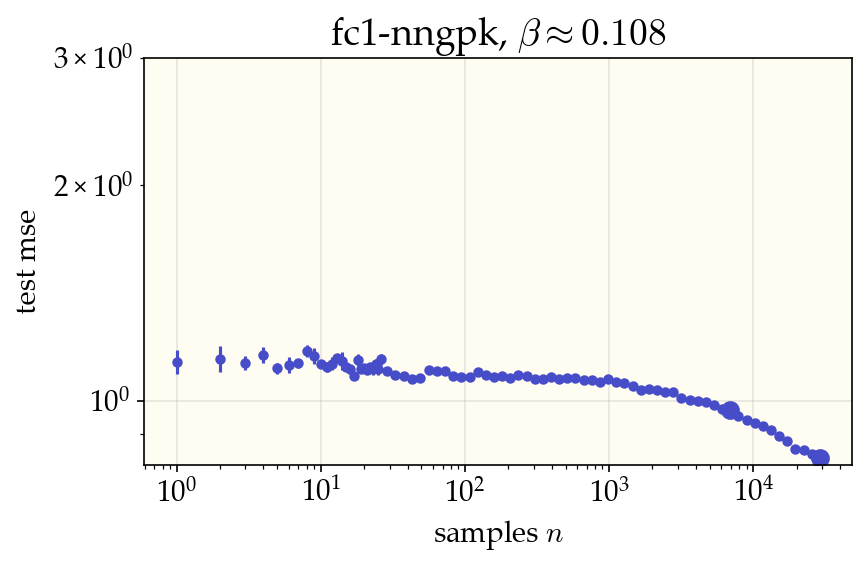

In [113]:
ax = plt.gca()

color = get_color(3)
sizes = eigstats["sizes"]
test_mses = eigstats["test_mses"]
test_mean, test_std = test_mses.mean(axis=0), test_mses.std(axis=0)
n_trials = test_mses.shape[0]

ax.errorbar(sizes, test_mean, yerr=test_std/np.sqrt(n_trials), ls='none',
            marker='o', markersize=4, color=color)

start, end = 68, len(sizes)-1
endpts = [start, end]
x1, x2 = sizes[endpts]
y1, y2 = test_mean[endpts]
beta = -np.log(y2/y1) / np.log(x2/x1)
ax.plot((x1, x2), (y1, y2), color=color, ls='none',
        marker='o', markersize=8)

ax.set_title(f"{expt.expt_name}, $\\beta\\approx{{{beta:.3f}}}$")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('samples $n$')
ax.set_ylabel('test mse')
ax.set_ylim(top=3)
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()

## Fitting ratio

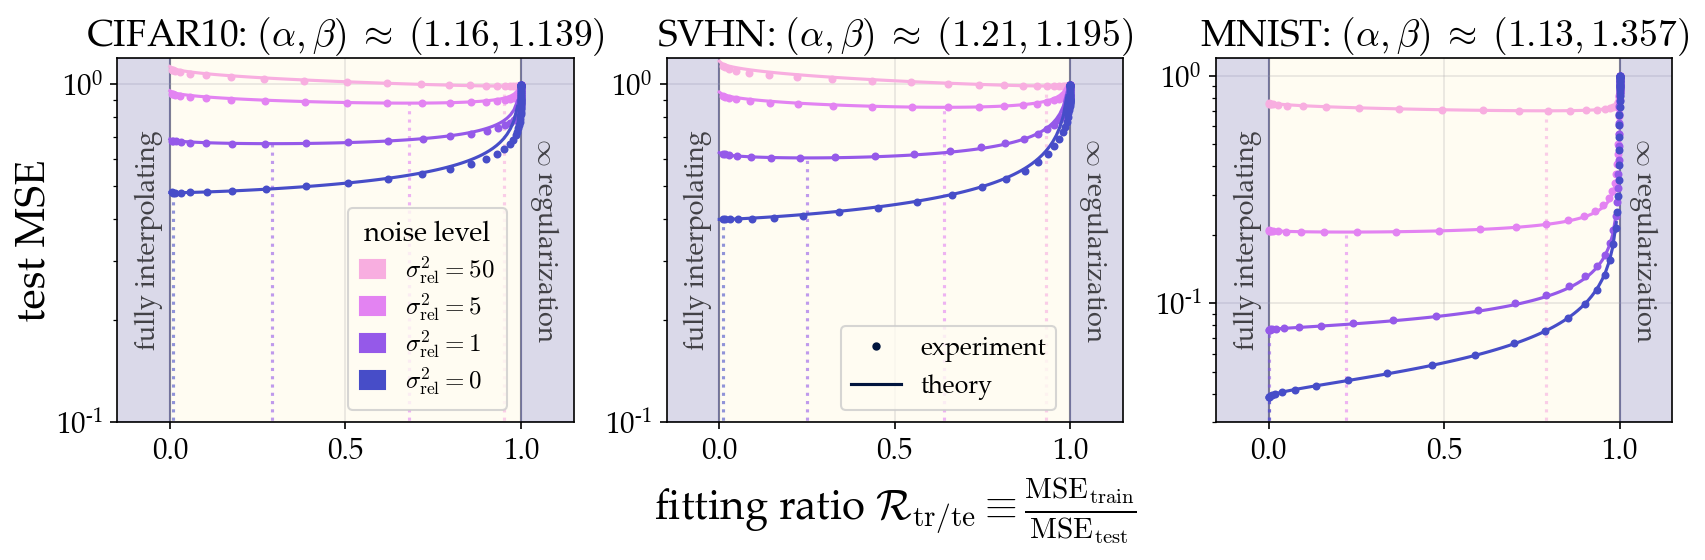

In [76]:

def mse_theory(R, a, b, noise, n):
    R2 = np.sqrt(R)
    pi = np.pi
    err = 1
    err *= pi**b * (a-b+1) * np.sin(pi/a) * (1/np.sin(pi*(b-1)/a))
    err *= (1 - R2 + a*noise*((1-R2)**b)) / (1 + (a-1)*R2)
    err *= (a * np.sin(pi/a) * (1-R2))**(-b)
    err *= n**(-(b-1))
    return err

fig, axes = plt.subplots(ncols=3, figsize=(12,3))

plot_params = {
    "datasets": ["mnist", "svhn", "cifar10"],
    "titles": ["MNIST", "SVHN", "CIFAR10"],
    "ymin": [0.03, 0.1, 0.1],
    "alpha": [1.13, 1.21, 1.16],
    "beta": [1.357, 1.195, 1.139],    
}
permute = [2, 1, 0]

for i, ax in enumerate(axes):
    i = permute[i]
    
    dataset_name = plot_params["datasets"][i]
    expt_info = ExptDetails(0, 10, dataset_name)
    work_dir = f"../results/{dataset_name}/{expt_info.expt_name}"
    
    expt = ExperimentResults.load(f"{work_dir}/optridge.expt")
    ridges = expt.get_axis("ridge")
    noises = expt.get_axis("noise")
    alpha = plot_params["alpha"][i]
    beta = plot_params["beta"][i]

    for j, noise in enumerate(noises[::-1]):
        # test_mse, train_mse = test_mses[noise], train_mses[noise]
        test_mse, _ = expt.get(stats_axis='trial', noise=noise, result="test_mse")
        train_mse, _ = expt.get(stats_axis='trial', noise=noise, result="train_mse")
        
        R = train_mse/test_mse
        
        R_thry = np.linspace(0, 1, 100, endpoint=False)
        thry = mse_theory(R_thry, alpha, beta, noise, 30000)
        pf = test_mse.min()/thry.min()
        thry *= pf
        ax.plot(R_thry, thry, color=get_color(j), label=f"$\sigma^2_\mathrm{{rel}}={noise}$", zorder=2)
        
        ax.scatter(R, test_mse, s=8, color=get_color(j), zorder=2)
        minidx = thry.argmin()
        ax.vlines(R_thry[minidx], 0, thry[minidx], ls=':', alpha=0.6, color=get_color(j), zorder=1)

    ax.vlines(0, 0, 1.5, color='k', lw=1, alpha=0.5, zorder=-4)
    ax.axvspan(1, 1.25, color=get_color(3), alpha=0.2)
    ax.axvspan(-0.25, 0, color=get_color(3), alpha=0.2)
    ax.vlines(1, 0, 1.5, color='k', lw=1, alpha=0.5, zorder=-4)
    
    ymin = plot_params["ymin"][i]
    ymid = np.sqrt(ymin*1.2)
    ax.text(-0.02, ymid, "fully interpolating", rotation=90, ha='right', va='center', size=13, alpha=0.7)
    ax.text(1.02, ymid, "$\infty$ regularization", rotation=-90, ha='left', va='center', size=13, alpha=0.7)
    ax.set_yscale('log')
    
    title = f"{plot_params['titles'][i]}: $(\\alpha,\\beta) \\;\\approx \\;({alpha},{beta})$"
    ax.set_title(title)
    ax.set_ylim(ymin, 1.2)
    ax.set_xlim(-.15, 1.15)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('fitting ratio $\mathcal{R}_\mathrm{tr/te}\equiv\\frac{\mathrm{MSE}_\mathrm{train}}{\mathrm{MSE}_\mathrm{test}}}$',
           size="x-large")
plt.ylabel('test MSE', size="x-large")
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
fig.subplots_adjust(bottom=0)
plt.figlegend(
    (
        Patch(color=get_color(0)),
        Patch(color=get_color(1)),
        Patch(color=get_color(2)),
        Patch(color=get_color(3)),),
    (
        f"$\sigma^2_\mathrm{{rel}}={noises[3]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[2]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[1]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[0]}$",),
    fontsize=12,
    title='noise level', title_fontsize=13,
    borderpad=.5, labelspacing=0.2,
    handlelength=1,
    ncol=1,
    bbox_to_anchor=(.332, .0),
    loc="lower right",
)
plt.figlegend(
    (
        Line2D([0], [0], color='xkcd:navy', ls="none", marker='.'),
        Line2D([0], [0], color='xkcd:navy'),),
    (
        "experiment",
        "theory",),
    fontsize=12,
    bbox_to_anchor=(.637,.0),
    loc="lower right",
)
plt.savefig("fitting-ratio.pdf", bbox_inches="tight")

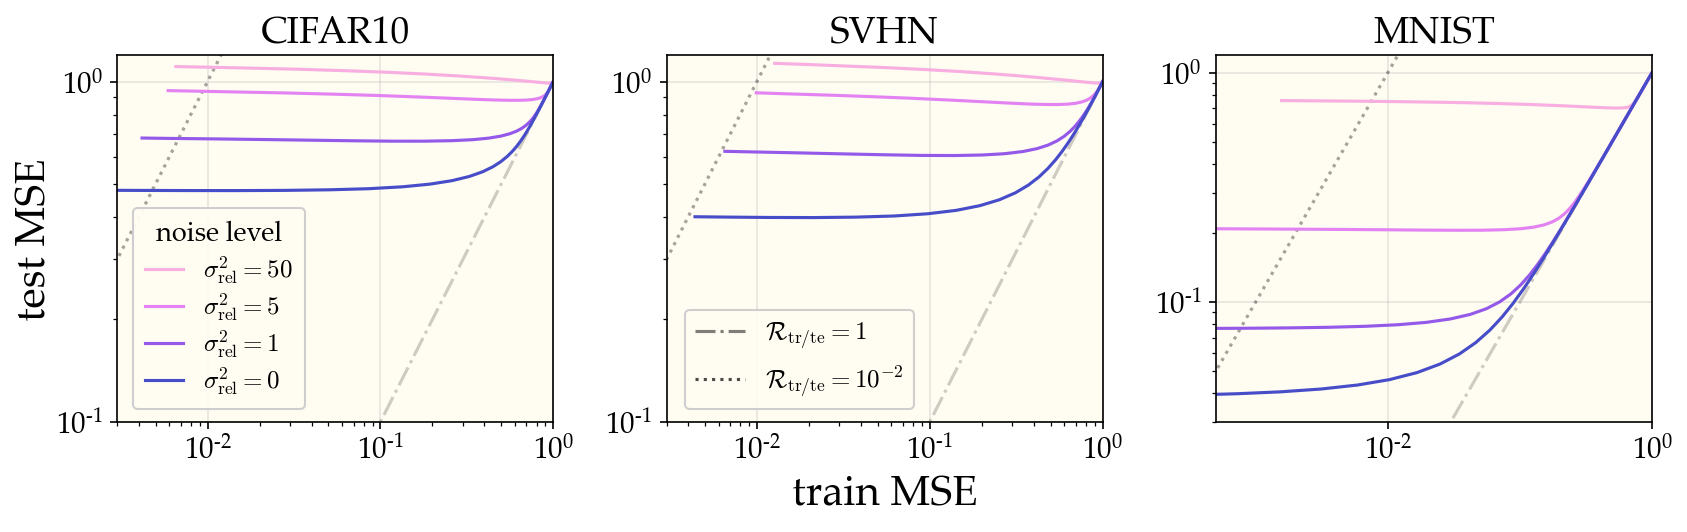

In [245]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3))

plot_params = {
    "datasets": ["mnist", "svhn", "cifar10"],
    "titles": ["MNIST", "SVHN", "CIFAR10"],
    "xmin": [5e-4, 3e-3, 3e-3],
    "ymin": [0.03, 0.1, 0.1],
}

permute = [2, 1, 0]
for i, ax in enumerate(axes):
    i = permute[i]
    
    dataset_name = plot_params["datasets"][i]
    expt_info = ExptDetails(0, 10, dataset_name)
    work_dir = f"../results/{dataset_name}/{expt_info.expt_name}"
    
    expt = ExperimentResults.load(f"{work_dir}/optridge.expt")
    ridges = expt.get_axis("ridge")
    noises = expt.get_axis("noise")

    xmin = plot_params["xmin"][i]
    ymin = plot_params["ymin"][i]
    xx = np.logspace(np.log(xmin), 0, 10)
    for j, noise in enumerate(noises[::-1]):
        # test_mse, train_mse = test_mses[noise], train_mses[noise]
        test_mse, _ = expt.get(stats_axis='trial', noise=noise, result="test_mse")
        train_mse, _ = expt.get(stats_axis='trial', noise=noise, result="train_mse")
        
        ax.plot(train_mse, test_mse, color=get_color(j), zorder=2)
        ax.plot(xx, xx, color='k', alpha=0.05, ls='-.', zorder=1)
        ax.plot(xx, (1e2)*xx, color='k', alpha=0.1, ls=':', zorder=1)

    ax.set_title(plot_params["titles"][i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_ylim(ymin, 1.2)
    ax.set_xlim(xmin, 1)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('train MSE',
           size="x-large")
plt.ylabel('test MSE', size="x-large")
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
fig.subplots_adjust(bottom=0)
plt.figlegend(
    (
        Line2D([0], [0], color=get_color(0)),
        Line2D([0], [0], color=get_color(1)),
        Line2D([0], [0], color=get_color(2)),
        Line2D([0], [0], color=get_color(3)),),
    (
        f"$\sigma^2_\mathrm{{rel}}={noises[3]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[2]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[1]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[0]}$",),
    fontsize=12,
    title='noise level', title_fontsize=13,
    borderpad=.5, labelspacing=0.2,
    handlelength=1.5,
    ncol=1,
    bbox_to_anchor=(.11, .0),
    loc="lower left",
    framealpha=0.95,
)
plt.figlegend(
    (
        Line2D([0], [0], color='k', alpha=0.5, ls='-.'),
        Line2D([0], [0], color='k', alpha=0.7, ls=':'),),
    (
        "$\mathcal{R}_\mathrm{tr/te}=1$",
        "$\mathcal{R}_\mathrm{tr/te}=10^{-2}$",),
    fontsize=12,
    bbox_to_anchor=(.417, .0),
    loc="lower left",
    framealpha=0.95,
)
plt.savefig("plots/train-vs-test.pdf", bbox_inches = "tight")

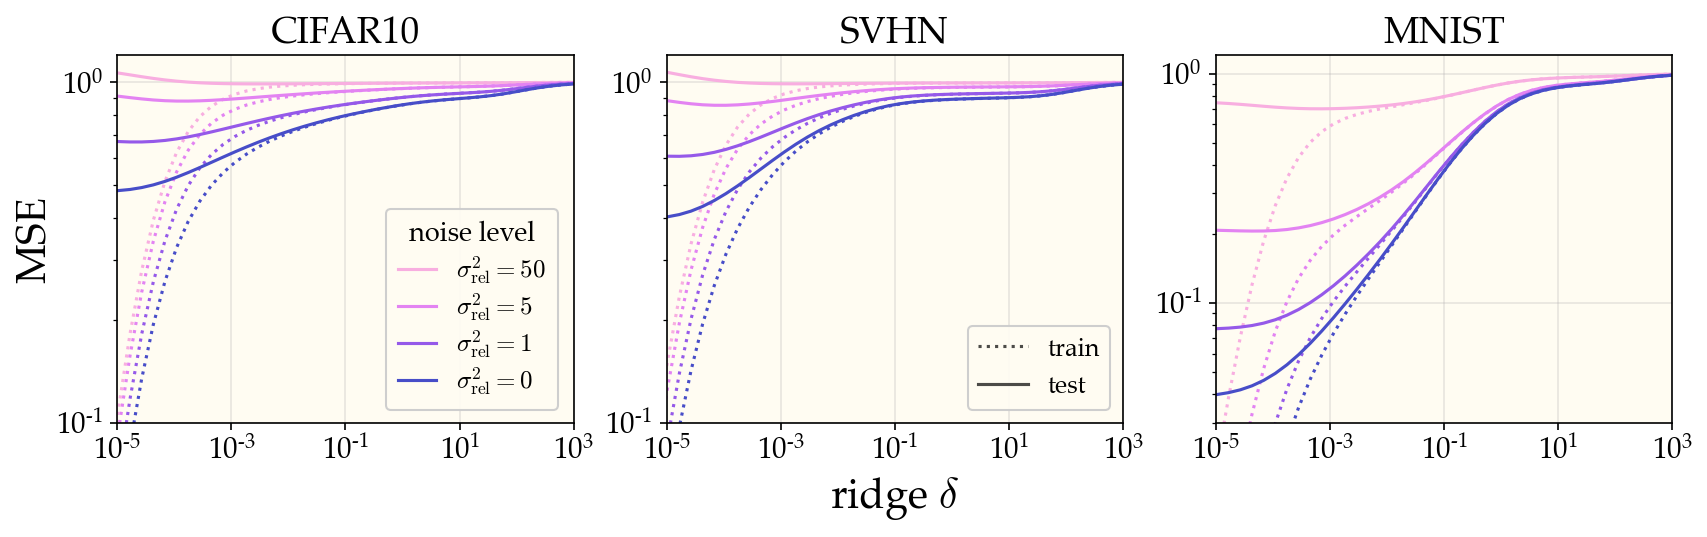

In [258]:
fig, axes = plt.subplots(ncols=3, figsize=(12,3))

plot_params = {
    "datasets": ["mnist", "svhn", "cifar10"],
    "titles": ["MNIST", "SVHN", "CIFAR10"],
    "ymin": [0.03, 0.1, 0.1],
}

permute = [2, 1, 0]
for i, ax in enumerate(axes):
    i = permute[i]
    
    dataset_name = plot_params["datasets"][i]
    expt_info = ExptDetails(0, 10, dataset_name)
    work_dir = f"../results/{dataset_name}/{expt_info.expt_name}"
    
    expt = ExperimentResults.load(f"{work_dir}/optridge.expt")
    ridges = expt.get_axis("ridge")
    noises = expt.get_axis("noise")

    ymin = plot_params["ymin"][i]
    for j, noise in enumerate(noises[::-1]):
        # test_mse, train_mse = test_mses[noise], train_mses[noise]
        test_mse, _ = expt.get(stats_axis='trial', noise=noise, result="test_mse")
        train_mse, _ = expt.get(stats_axis='trial', noise=noise, result="train_mse")
        
        ax.plot(ridges, test_mse, color=get_color(j), zorder=2)
        ax.plot(ridges, train_mse, color=get_color(j), ls=":", zorder=2)

    ax.set_title(plot_params["titles"][i])
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlim(1e-5, 1e3)
    ax.set_ylim(ymin, 1.2)
    ax.set_axisbelow(True)
    ax.grid(alpha=0.3, zorder=-5)

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('ridge $\\delta$',
           size="x-large")
plt.ylabel('MSE', size="x-large")
plt.ticklabel_format(axis='y', style='plain')
plt.tight_layout()
fig.subplots_adjust(bottom=0)
plt.figlegend(
    (
        Line2D([0], [0], color=get_color(0)),
        Line2D([0], [0], color=get_color(1)),
        Line2D([0], [0], color=get_color(2)),
        Line2D([0], [0], color=get_color(3)),),
    (
        f"$\sigma^2_\mathrm{{rel}}={noises[3]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[2]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[1]}$",
        f"$\sigma^2_\mathrm{{rel}}={noises[0]}$",),
    fontsize=12,
    title='noise level', title_fontsize=13,
    borderpad=.5, labelspacing=0.2,
    handlelength=1.5,
    ncol=1,
    bbox_to_anchor=(.36, .0),
    loc="lower right",
    framealpha=0.95,
)
plt.figlegend(
    (
        Line2D([0], [0], color='k', alpha=0.7, ls=':'),
        Line2D([0], [0], color='k', alpha=0.7, ls='-'),),
    (
        "train",
        "test",),
    fontsize=12,
    bbox_to_anchor=(.667, .0),
    loc="lower right",
    framealpha=0.95,
)
plt.savefig("plots/mse-vs-ridge.pdf", bbox_inches="tight")